In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from fsmodels import SklMultiExpFrequencyScan

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Base class

In [2]:
class BaseModel(BaseEstimator, RegressorMixin):
    
    
    def __init__(self,
                 filling_pulse = 20*10**-6,
                 n_exps = 1,
                 learning_rate = 0.1,
                 n_iters = 1000,
                 stop_val = None,
                 verbose = False
                ):
        self.filling_pulse = filling_pulse
        self.n_exps = n_exps
        self.learning_rate = learning_rate
        self.n_iters = n_iters
        self.stop_val = stop_val
        self.verbose = verbose

        
    def _get_phi(self,
                 frequency_powers,
                 time_constant_power,
                ):
        time_constant = tf.pow(10.0, time_constant_power)
        frequency = tf.pow(10.0, frequency_powers)

        a = time_constant * frequency
        b = self.filling_pulse * frequency

        exp0 = tf.exp(-0.05 / (a))
        exp1 = tf.exp((b - 0.45) / (a))
        exp2 = tf.exp(-0.5 / (a))
        exp3 = tf.exp((b - 0.95) / (a))

        return a * exp0 * (1.0 - exp1 - exp2 + exp3)


    def _get_M(self,
               time_constant_power,
               learning_rate=0.2, 
               n_iters=100, 
               stop_val = 10**-10
              ):
        prev_loss = tf.Variable(np.inf, dtype='float64')
        max_freq_pow = tf.Variable(-time_constant_power, dtype='float64')

        for _ in range(n_iters):
            with tf.GradientTape() as tape:

                current_loss = 0.0 - self._get_phi(max_freq_pow, time_constant_power)

            if stop_val is not None:
                if tf.abs(current_loss - prev_loss) < stop_val:
                    break

            dfreq_pow = tape.gradient(current_loss, max_freq_pow)
            max_freq_pow.assign_sub(learning_rate * dfreq_pow)

            prev_loss = current_loss

        return -1 / current_loss
    
    
    def predict(self, X):
        f_powers = tf.Variable(X, dtype='float64')
        return self._get_dlts(X=f_powers).numpy()
    
    
    def _get_dlts(self, X):
        raise NotImplementedError('Implement _get_dlts() in ' + self.__class__.__name__ + '.') 
        
    def fit(self, X, y):
        raise NotImplementedError('Implement fit() in ' + self.__class__.__name__ + '.') 
    
    
    @property
    def exps_params_(self):
        '''exps_params_ = [[timeconstant_power_0, amplitude_0],
                           [timeconstant_power_1, amplitude_1],
                           ... ,
                           [timeconstant_power_n, amplitude_n]]'''
        return self._exps_params.numpy()
    
    @exps_params_.setter
    def exps_params_(self, val):
        value = tf.Variable(val, dtype='float64')
        
        condition = not(len(value.shape) == 2 and 
                        value.shape[0] == self.n_exps and 
                        value.shape[1] == 2)
        
        if condition:
            raise ValueError('The shape of exps_params must be equal [to n_exps, 2], ' + 
                             f'specifically {[self.n_exps, 2]}.')
        self._exps_params = value
        
        self._M = tf.map_fn(fn = self._get_M, elems=self._exps_params[:, 0])
        
        
    @property
    def fit_results_(self):
        return self._fit_results
    
    
    def print_all_params(self, iteration_number=None, loss=None):
        if iteration_number is not None:
            print(f'iteration # {iteration_number}')
            
        if loss is not None:
            print(f'Loss: {loss}')
        
        params = 
        
        
        print()

# Single exponential model class

In [3]:
class SklSingleExpFrequencyScan(BaseModel):
    
    
    def __init__(self,
                 filling_pulse = 20*10**-6,
                 fit_p_coef = True,
                 learning_rate = 0.1,
                 n_iters = 1000,
                 stop_val = None,
                 verbose = False
                ):
        
        super().__init__(filling_pulse = filling_pulse,
                         n_exps = 1,
                         learning_rate = learning_rate,
                         n_iters = n_iters,
                         stop_val = stop_val,
                         verbose = verbose)
        
        self.fit_p_coef = fit_p_coef
        
        
    def _get_dlts(self, X):
        frequency_powers = tf.Variable(X, dtype='float64')
        
        phi = self._get_phi(frequency_powers, self._exps_params[0, 0])
        
        return self._exps_params[0, 1] * tf.pow(self._M * phi, self._p_coef)
    
    
    @property
    def p_coef_(self):
        return self._p_coef.numpy()

    @p_coef_.setter
    def p_coef_(self, val):
        self._p_coef = tf.Variable(val, dtype='float64')
        
        
    def fit(self, X, y):
        
        self.exps_params_ = [[np.random.uniform(low=-3.5, high=-1), 3.5]]
        self.p_coef_ = 1.0
        
        frequency_powers = tf.Variable(X, dtype='float64')
        dlts = tf.Variable(y, dtype='float64')
        
        prev_loss = tf.Variable(np.inf, dtype='float64')
        
        
        
        return self

In [4]:
fs = SklSingleExpFrequencyScan()
fs

SklSingleExpFrequencyScan()

In [5]:
fs.get_params()

{'filling_pulse': 1.9999999999999998e-05,
 'fit_p_coef': True,
 'learning_rate': 0.1,
 'n_iters': 1000,
 'stop_val': None,
 'verbose': False}

In [6]:
X = np.linspace(0, 3.5, 100)

fs.exps_params_ = [[-2.5, 1]]
fs.p_coef_ = 1

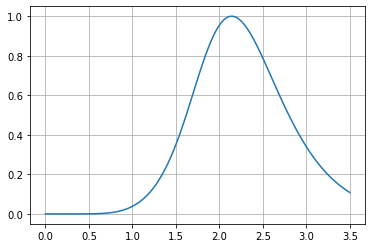

In [7]:
y = fs.predict(X)

plt.plot(X, y)
plt.grid()
plt.show()

In [8]:
fs.fit(X, y)

SklSingleExpFrequencyScan()

In [11]:
fs.get_params()

{'filling_pulse': 1.9999999999999998e-05,
 'fit_p_coef': True,
 'learning_rate': 0.1,
 'n_iters': 1000,
 'stop_val': None,
 'verbose': False}